In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px

import category_encoders as ce

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import time

# загрузим библиотеку для анализа текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
from nltk.corpus import stopwords


from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif 

# Импортируем библиотеки для обучения модели:
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/tmp/ipykernel_20/447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [13]:
data.nunique()

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1472
lng                                             1472
sample                                             2
reviewer_score                                    38
dtype: int64

В датасете присутствуют пропуски в признаках lat и lng. Всего категориалных признаков - 8, численных - 9. Всего уникальных значений - 1492 наименований отеля, 1493 - адресов отеля, значит у нас есть два отеля с одинаковым наименованием. Уникальных значений долготы и ширины - 1472, что говорит о том, что у 21 отеля не указаны координаты.

In [14]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


# Обработка пропущенных значений

In [15]:
#определим долю пропущенных значений
cols_null_percent = data.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0]
cols_with_null

lat    0.633655
lng    0.633655
dtype: float64

Пропуски составляют менее 1%. Исходя из того, что у нас нет координат для 21 отеля, заполнение пропусков будет сделующим: найдем отели с пропусками, получим их координаты по адресу отеля, и заполним координаты актуальными значениями.

In [16]:
# создадим словарь из отелей и их адресов, у которых не заполнены координаты
lng_with_null = pd.isnull(data.lng)
hotel_name_lng_with_null = data[lng_with_null].groupby('hotel_name')['hotel_address'].max().to_dict()
hotel_name_lng_with_null

{'Austria Trend Hotel Schloss Wilhelminenberg Wien': 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
 'City Hotel Deutschmeister': 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
 'Cordial Theaterhotel Wien': 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
 'Derag Livinghotel Kaiser Franz Joseph Vienna': 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
 'Fleming s Selection Hotel Wien City': 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
 'Holiday Inn Paris Montmartre': '23 Rue Damr mont 18th arr 75018 Paris France',
 'Hotel Advance': 'Sep lveda 180 Eixample 08011 Barcelona Spain',
 'Hotel Atlanta': 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
 'Hotel City Central': 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
 'Hotel Daniel Vienna': 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
 'Hotel Park Villa': 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
 'Hotel Pension Baron am Schottentor': 'W hringer Stra

In [17]:
# создадим словарь адресов отелей и их координат(список получен вруную, так отелей немного)
dict_hotels = {'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': (48.221415,
  16.2874559),
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': (48.2211573, 16.3620293),
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': (48.2098335, 16.3475615),
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': (48.2462468,
  16.3387236),
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': (48.2098335, 16.3475615),
 '23 Rue Damr mont 18th arr 75018 Paris France': (48.8888806, 2.3331948),
 'Sep lveda 180 Eixample 08011 Barcelona Spain': (41.3832344, 2.162940206993912),
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': (48.2203284, 16.3558289),
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': (48.2278937, 16.3882026),
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': (48.1888627, 16.3838516356697),
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': (48.2331682, 16.3470804),
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': (48.2212841, 16.3546402),
 '4 rue de la P pini re 8th arr 75008 Paris France': (48.875248, 2.3233746),
 '20 Rue De La Ga t 14th arr 75014 Paris France': (48.839701, 2.323519),
 'Bail n 4 6 Eixample 08010 Barcelona Spain': (41.3929354, 2.1758883),
 'Pau Clar s 122 Eixample 08009 Barcelona Spain': (41.3927154, 2.1674921),
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria': (48.18672145, 16.420653090404993)}

# разделим словарь с координатами на два словаря с долготой и широтой отдельно, и заполним пустые ячейки
dict_lat={}
for k in dict_hotels.keys():
    dict_lat[k]=dict_hotels.get(k)[0]

dict_lng={}
for k in dict_hotels.keys():
    dict_lng[k]=dict_hotels.get(k)[1]


mask1=data['lat'].astype('str').isin(['NaN','nan'])
data.loc[mask1,'lat']=data.loc[mask1,'hotel_address'].map(dict_lat)

mask2=data['lng'].astype('str').isin(['NaN','nan'])
data.loc[mask2,'lng']=data.loc[mask2,'hotel_address'].map(dict_lng)

# Преобразование признаков

In [18]:
data['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

In [19]:
#выделим отдельно новый признак city из hotel_address
def get_city(address):
    list_address=address.split()
    if list_address[-1] == 'Kingdom':
        city=list_address[-5]
    else:
        city=list_address[-2]
    return city
        
data['city']=data['hotel_address'].apply(get_city)
data['city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

In [20]:
# значений меньше 15, поэтому будем использовать однократное кодирование.
data = pd.get_dummies(data, columns=['city'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Признак review_date и days_since_review
Приведем признак к формату datetime. Выделим из признака месяц размещения отзыва, так как возможно есть связь между месяцем и оценкой, которую оставляют клиенты отеля.

In [21]:
# выделим месяц из даты размещенимя отзыва
data['review_date']=pd.to_datetime(data['review_date'])
data['month_review']=data['review_date'].dt.month
data['month_review'].value_counts()

8     50672
7     49318
5     46490
10    43843
6     42896
4     42883
9     42428
1     42151
3     41110
12    39607
2     38370
11    35970
Name: month_review, dtype: int64

In [22]:
# признак days_since_review 
data['days_since_review'].value_counts()

1 days     2585
322 day    2308
120 day    2284
338 day    1963
534 day    1940
           ... 
327 day     199
615 day     194
122 day     192
124 day     173
123 day     143
Name: days_since_review, Length: 731, dtype: int64

In [23]:
# преобразуем в числовой формат
data['days_since_review']=data['days_since_review'].apply(lambda x: x.split(' ')[0])

# Признак reviewer_nationality
Этот признак имеет 227 уникальных значений, поэтому мы выберем из них 20 самых многочисленные значения, а остальные отнесем к группе "Прочие". Далее создадим новые признаки методом бинарного кодирования.

In [24]:
# составим топ-20 национальностей по количеству отзывов
top_nationalities=data['reviewer_nationality'].value_counts().nlargest(20).index
data['top_reviewer_nationality']=data['reviewer_nationality'].apply(lambda x:x if x in top_nationalities else 'other' )
data['top_reviewer_nationality'].value_counts()

 United Kingdom               245246
other                          92646
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
Name: top_reviewer_nationality, dtype: int64

In [25]:
# так как признаков мы создали больше 20, воспользуемся методом бинарного кодирования
bin_encoder = ce.BinaryEncoder(cols=['top_reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['top_reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

# Признаки negative_review и positive_review
Для анализа отзывов воспользуемся функцией анализа тональности из библиотеки nltk, для этого подготовим текст для обработки: проведем токенизацию и очистку от стоп-слов.

In [27]:
# переведем в нижний регистр и удалим ненужные пробелы
data['negative_review']=data['negative_review'].str.lower().str.strip()
data['positive_review']=data['positive_review'].str.lower().str.strip()

In [28]:
data['negative_review'].value_counts().nlargest(20)

no negative                127890
nothing                     21185
n a                          1815
none                         1501
                              849
nothing really                656
small room                    570
all good                      545
breakfast                     545
no complaints                 523
location                      502
nothing at all                467
everything                    420
nothing to dislike            373
price                         348
nil                           332
small rooms                   307
everything was perfect        276
na                            272
can t think of anything       250
Name: negative_review, dtype: int64

In [29]:
data['positive_review'].value_counts().nlargest(20)

no positive                   35946
location                      11945
everything                     3314
nothing                        1731
great location                 1687
the location                   1606
good location                  1496
breakfast                       795
friendly staff                  733
excellent location              639
staff                           553
location and staff              452
location staff                  432
location location location      345
location was great              328
good breakfast                  316
everything was perfect          316
location was good               312
comfy bed                       303
perfect location                287
Name: positive_review, dtype: int64

In [30]:
# словосочетание "no negative" оценивается как негативное, поэтому этот комментарий я заменю на нейтральное 'nothing', аналогично поступлю и с "no positive'.
data['negative_review']=data['negative_review'].apply(lambda x:x if x!= "no negative" else 'nothing')
data['positive_review']=data['positive_review'].apply(lambda x:x if x!= "no positive" else 'nothing')
# токенизация текста
data['negative_review_token'] = data['negative_review'].str.split()
data['positive_review_token'] = data['positive_review'].str.split()

In [31]:
%%time

# очистим от стоп-слов
def remove_stopwords(text):
    return " ".join([word for word in text if word not in stopwords])

stopwords = stopwords.words('english')

data['cleared_negative_review']=data['negative_review_token'].apply(remove_stopwords)
data['cleared_positive_review']=data['positive_review_token'].apply(remove_stopwords)

CPU times: user 27.7 s, sys: 74.1 ms, total: 27.8 s
Wall time: 27.8 s


In [32]:
%%time
# проведем сентимент-анализ и создадим новые признаки

sent_analyzer = SentimentIntensityAnalyzer()

data['neg_compound'] = data['cleared_negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)["compound"])
data['neg_neg'] = data['cleared_negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)["neg"])
data['neg_neu'] = data['cleared_negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)["neu"])
data['neg_pos'] = data['cleared_negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)["pos"])

data['pos_compound'] = data["cleared_positive_review"].apply(lambda x: sent_analyzer.polarity_scores(x)["compound"])
data['pos_neg'] = data["cleared_positive_review"].apply(lambda x: sent_analyzer.polarity_scores(x)["neg"])
data['pos_neu'] = data["cleared_positive_review"].apply(lambda x: sent_analyzer.polarity_scores(x)["neu"])
data['pos_pos'] = data["cleared_positive_review"].apply(lambda x: sent_analyzer.polarity_scores(x)["pos"])

CPU times: user 9min 31s, sys: 275 ms, total: 9min 31s
Wall time: 9min 31s


# Признак tags

In [33]:
# создадим словарь тегов и количества его упоминаний
tag_cnt = {}
for x in data.tags:
    for i in x[2:-2].strip().split(' \', \' '):
        if i in tag_cnt:
            tag_cnt[i] +=1
        else:
            tag_cnt[i] = 1

In [34]:
# создадим датафрейм для удобства анализа
data_tags = pd.DataFrame.from_dict(tag_cnt, orient = 'index')
print(f'Количество уникальных значений тегов: {data_tags[0].nunique()}')
print(f'Доля значений 20 самых популярных тегов: {round(data_tags[0].sort_values().nlargest(20).sum()/data_tags[0].sort_values().sum()*100)}%')
print(f'20 самых популярных тегов \n{data_tags[0].sort_values().nlargest(20)}')

Количество уникальных значений тегов: 382
Доля значений 20 самых популярных тегов: 85%
20 самых популярных тегов 
Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Stayed 4 nights                    47817
Double Room                        35207
Standard Double Room               32248
Superior Double Room               31393
Family with older children         26349
Deluxe Double Room                 24823
Double or Twin Room                22393
Stayed 5 nights                    20845
Standard Double or Twin Room       17483
Classic Double Room                16989
Name: 0, dtype: int64


In [35]:
# создадим новые признаки из 20 популярных тегов
data['Leisure trip']=data.tags.apply(lambda x:1 if 'Leisure trip' in x else 0)
data['Business trip']=data.tags.apply(lambda x:1 if 'Business trip' in x else 0)
data['Submitted from a mobile device']=data.tags.apply(lambda x:1 if 'Submitted from a mobile device' in x else 0)
data['Stayed 1 night']=data.tags.apply(lambda x:1 if 'Stayed 1 night' in x else 0)
data['Stayed 2 nights']=data.tags.apply(lambda x:1 if 'Stayed 2 nights' in x else 0)
data['Solo traveler']=data.tags.apply(lambda x:1 if 'Solo traveler' in x else 0)
data['Stayed 3 nights']=data.tags.apply(lambda x:1 if 'Stayed 3 nights'in x else 0)
data['Group']=data.tags.apply(lambda x:1 if 'Group' in x else 0)
data['Family with young children']=data.tags.apply(lambda x:1 if 'Family with young children'in x else 0)
data['Stayed 4 nights']=data.tags.apply(lambda x:1 if 'Stayed 4 nights' in x else 0)
data['Family with older children']=data.tags.apply(lambda x:1 if 'Family with older children' in x else 0)
data['Stayed 5 nights']=data.tags.apply(lambda x:1 if 'Stayed 5 nights' in x else 0)
data['Double Room']=data.tags.apply(lambda x:1 if 'Double Room'in x else 0)
data['Standard Double Room']=data.tags.apply(lambda x:1 if 'Standard Double Room' in x else 0)
data['Superior Double Room']=data.tags.apply(lambda x:1 if 'Superior Double Room' in x else 0)
data['Deluxe Double Room']=data.tags.apply(lambda x:1 if 'Deluxe Double Room' in x else 0)
data['Double or Twin Room']=data.tags.apply(lambda x:1 if 'Double or Twin Room'in x else 0)
data['Standard Double or Twin Room']=data.tags.apply(lambda x:1 if 'Standard Double or Twin Room'in x else 0)
data['Classic Double Room']=data.tags.apply(lambda x:1 if 'Classic Double Room'in x else 0)

# Отбор признаков

In [36]:
# удаляем строковые признаки 
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.drop('review_date', axis = 1, inplace=True)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 49 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [38]:
# непрерывные признаки
num_cols = ['total_number_of_reviews',
    'review_total_negative_word_counts',
    'additional_number_of_scoring',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given']

# категориальные признаки
cat_cols = ['average_score', 'lat', 'lng', 'city_Amsterdam','city_Barcelona','city_London','city_Milan','city_Paris',
     'city_Vienna','month_review', 'top_reviewer_nationality_0', 'top_reviewer_nationality_1', 'top_reviewer_nationality_2',
     'top_reviewer_nationality_3','top_reviewer_nationality_4','Leisure trip','Business trip','Submitted from a mobile device',
     'Stayed 1 night','Stayed 2 nights','Solo traveler', 'Stayed 3 nights', 'Group', 'Family with young children','Stayed 4 nights',
     'Family with older children','Stayed 5 nights','Double Room','Standard Double Room','Superior Double Room', 'Deluxe Double Room',
     'Double or Twin Room', 'Standard Double or Twin Room','Classic Double Room','neg_compound', 'pos_compound','neg_neg', 'neg_neu',
     'neg_pos', 'pos_neg','pos_neu', 'pos_pos' ]  

In [39]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [40]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [41]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 48), (386803, 48), (386803, 47), (309442, 47), (77361, 47))

<Axes: >

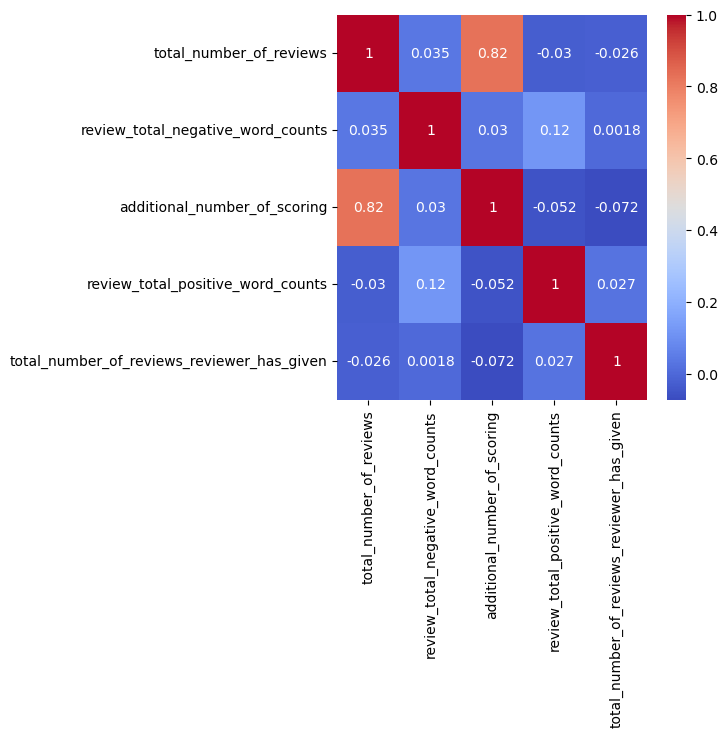

In [42]:
# проведем анализ му

plt.rcParams['figure.figsize'] = (5,5)
sns.heatmap(train_data[num_cols].corr(), annot=True, cmap='coolwarm')

<Axes: >

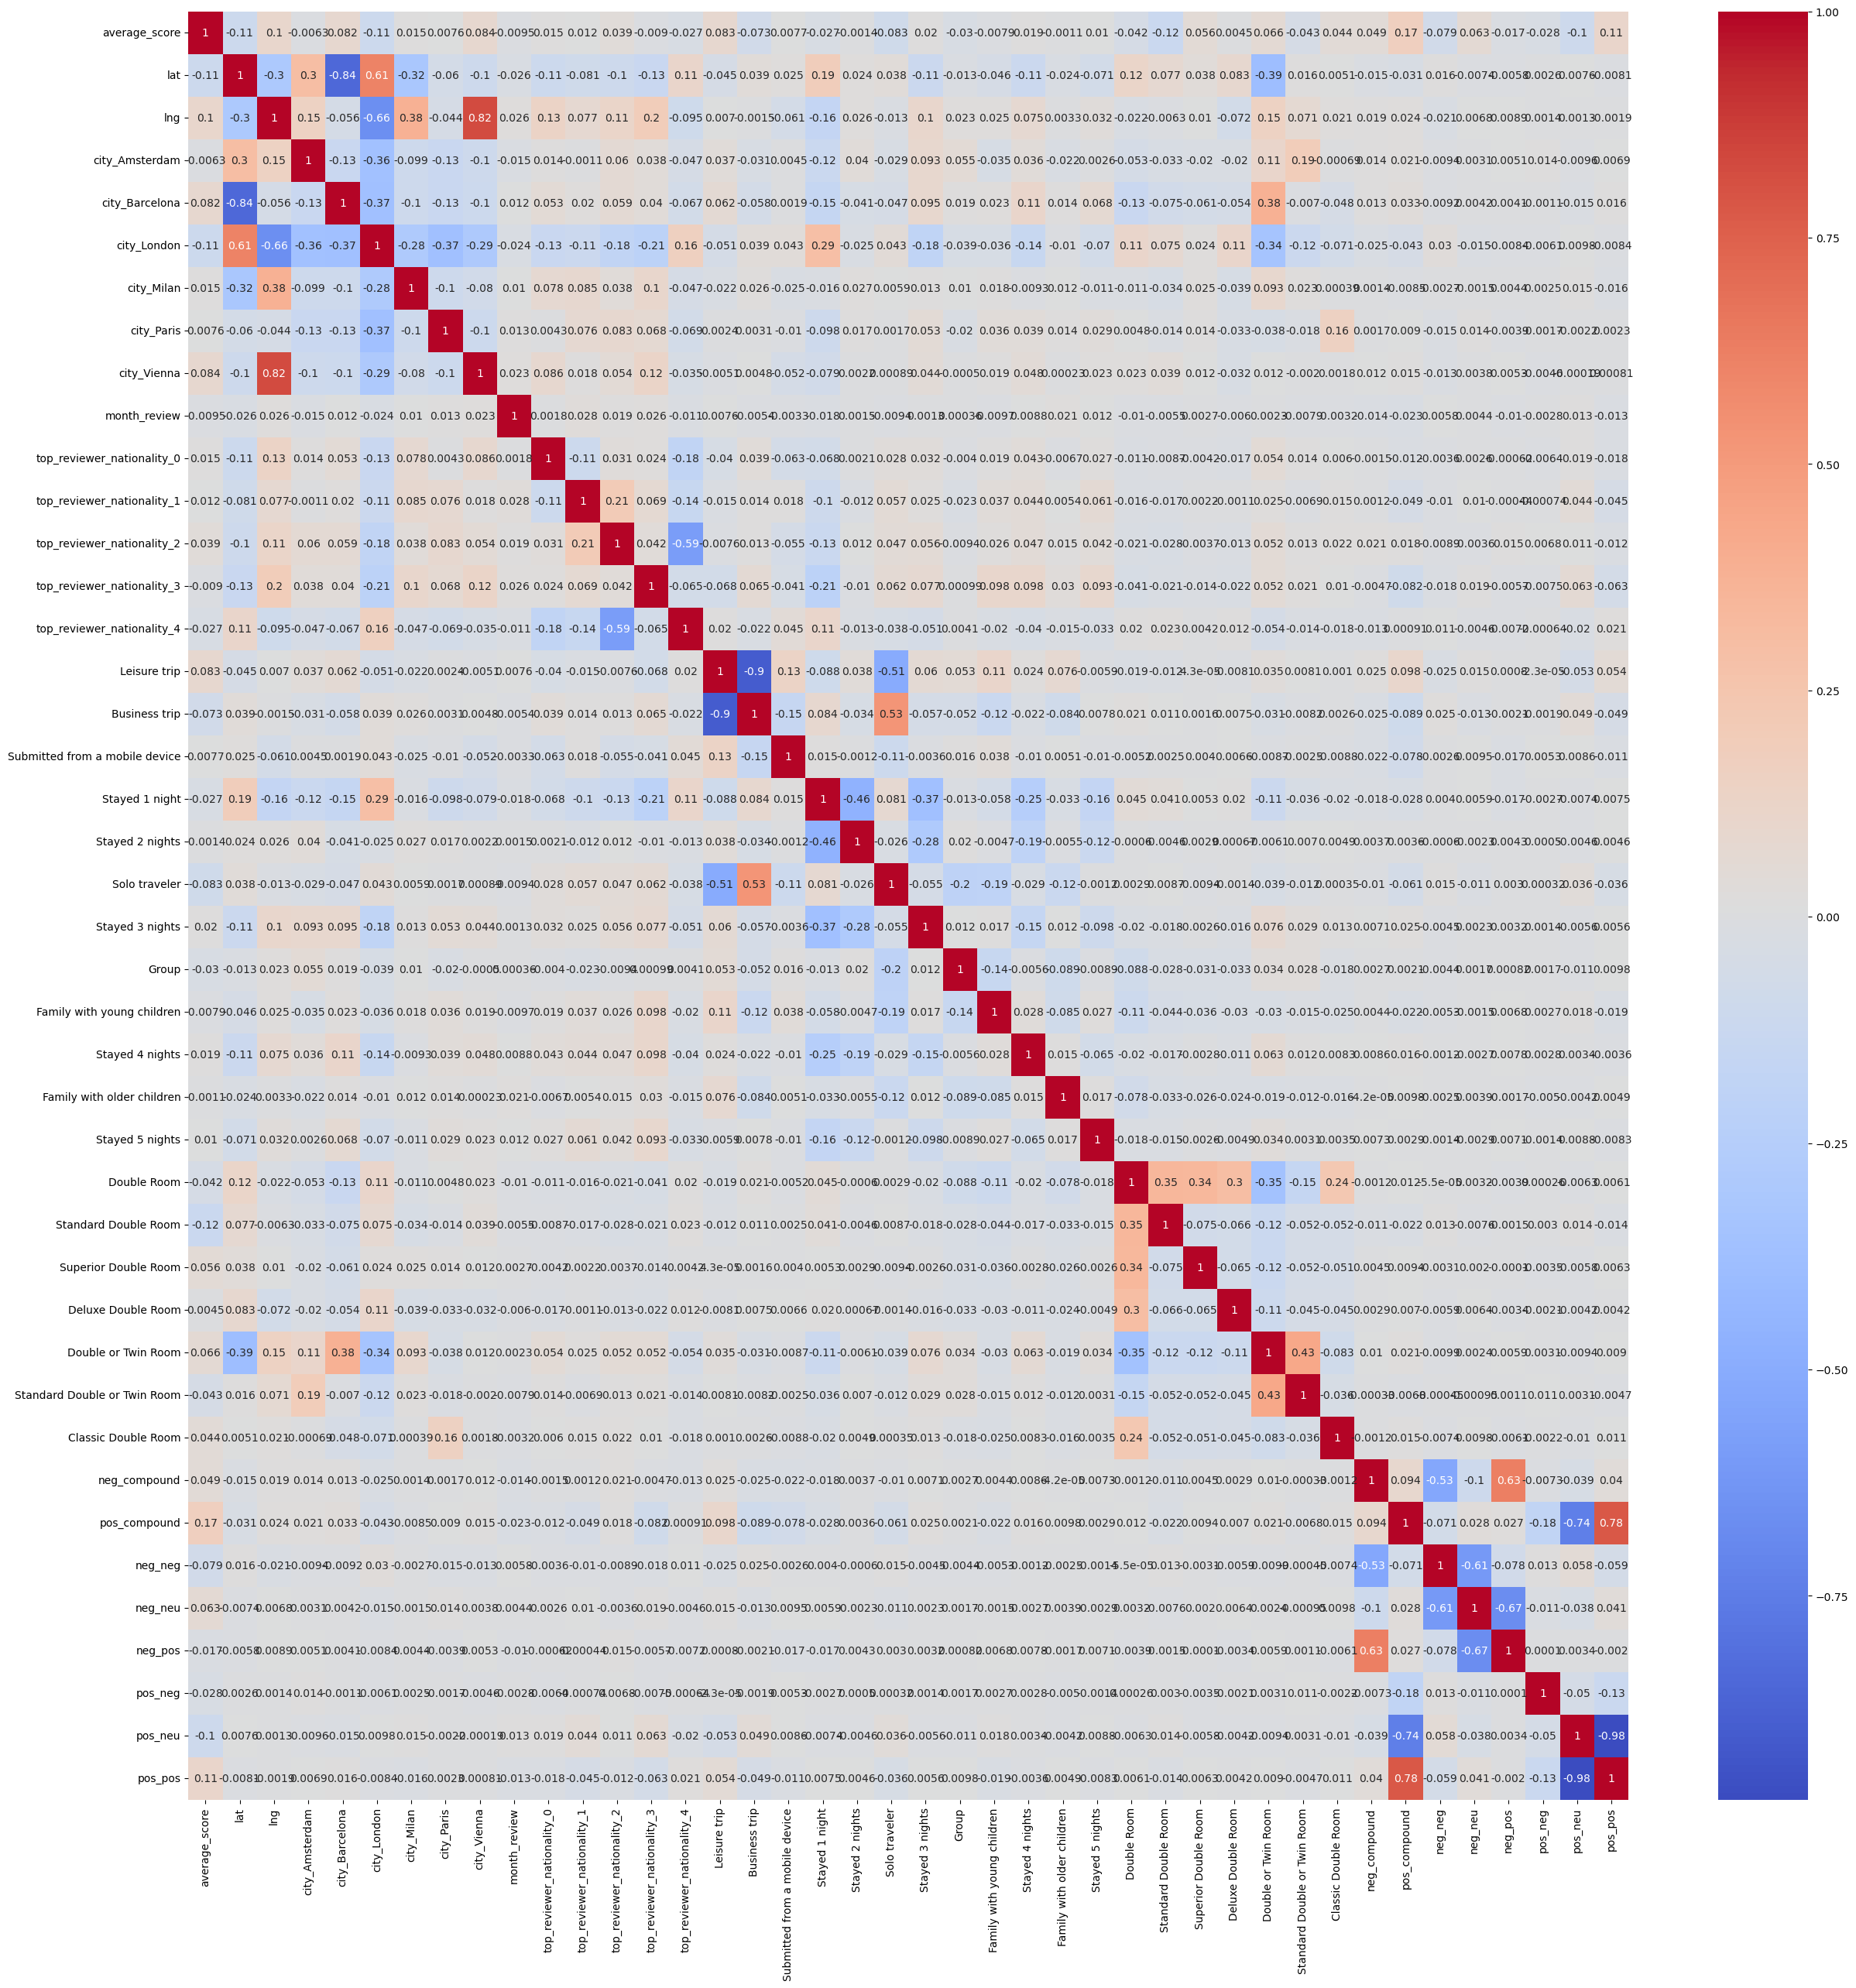

In [43]:
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(train_data[cat_cols].corr(), annot=True, cmap='coolwarm')

Пары с высокой корреляцией: lat-city Barcelona - 0.81, lng-city Vienna - 0.82, Leissure trip-Business trip - 0.9, pos-compound-pos-neu-0.77, pos-compound-pos-pos - 0.77, pos-neu-pos-pos-0.98.

Так как для проведения непараметрического теста хи-квадрат для категориальных признаков необходимы только положительные значения, сделаем новый список признаков без lat, lng, neg_compound', 'pos_compound','neg_neg', 'neg_neu','neg_pos', 'pos_neg','pos_neu','pos_pos'.

In [44]:
cat_cols2 = ['average_score', 'city_Amsterdam','city_Barcelona','city_London','city_Milan','city_Paris',
     'city_Vienna','month_review', 'top_reviewer_nationality_0', 'top_reviewer_nationality_1', 'top_reviewer_nationality_2',
     'top_reviewer_nationality_3','top_reviewer_nationality_4','Business trip','Submitted from a mobile device',
     'Stayed 1 night','Stayed 2 nights','Solo traveler', 'Stayed 3 nights', 'Group', 'Family with young children','Stayed 4 nights',
     'Family with older children','Stayed 5 nights','Double Room','Standard Double Room','Superior Double Room', 'Deluxe Double Room',
     'Double or Twin Room', 'Standard Double or Twin Room','Classic Double Room']  

<Axes: >

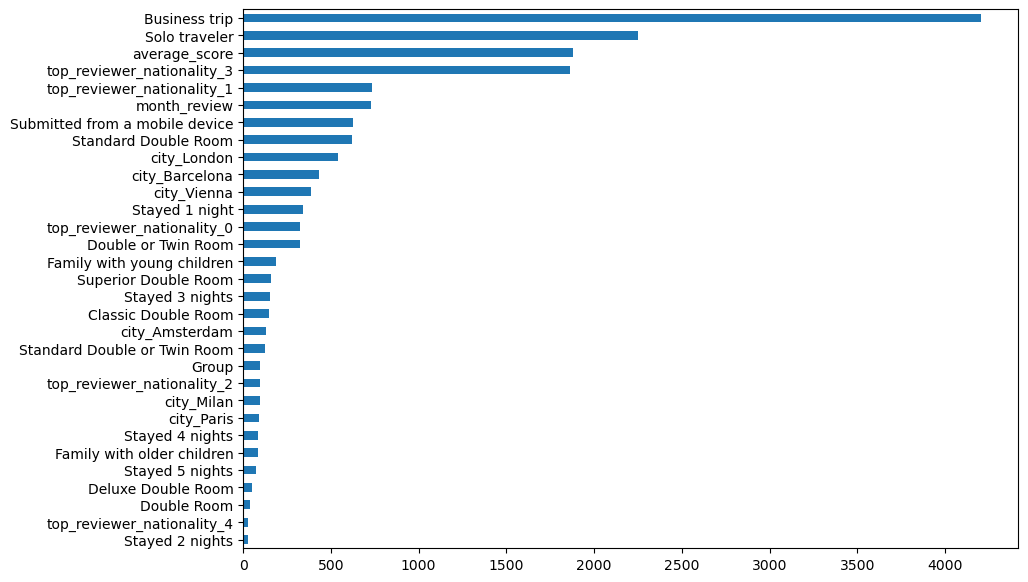

In [45]:
# тест Хи-квадрат
y=y.astype('int')

imp_cat = pd.Series(chi2(X[cat_cols2], y)[0], index=cat_cols2)
imp_cat.sort_values(inplace = True)

plt.rcParams['figure.figsize'] = (10,7)
imp_cat.plot(kind = 'barh')

<Axes: >

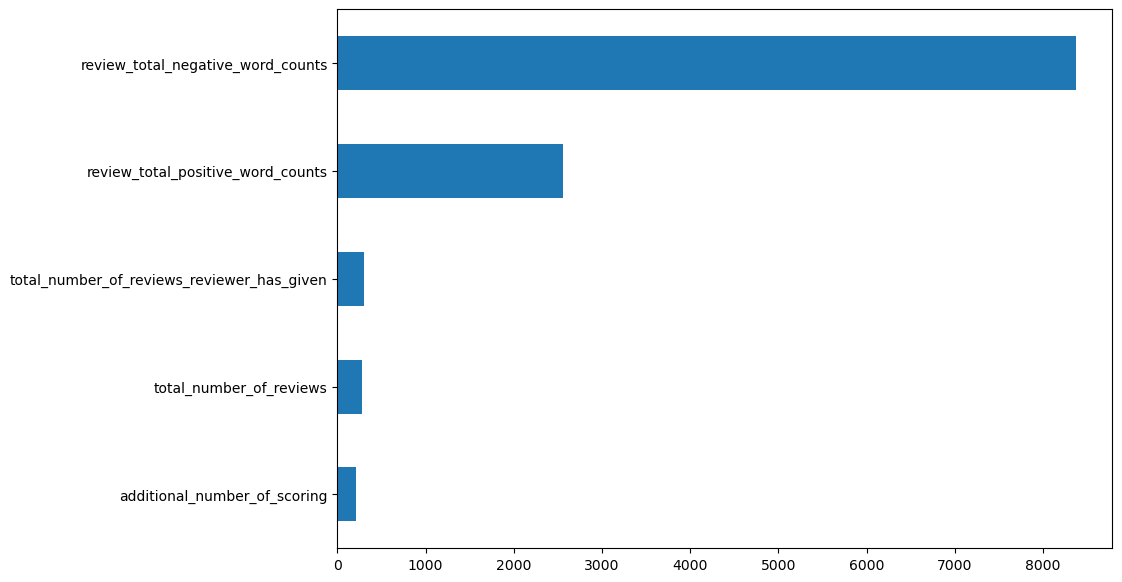

In [46]:
# тест ANOVA
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)

plt.rcParams['figure.figsize'] = (10,7)
imp_num.plot(kind = 'barh')

In [47]:
data[num_cols].describe()

,total_number_of_reviews,review_total_negative_word_counts,additional_number_of_scoring,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,2743.743944,18.539450,498.081836,17.776458,7.166001
std,2317.464868,29.690831,500.538467,21.804185,11.040228
min,43.000000,0.000000,1.000000,0.000000,1.000000
25%,1161.000000,2.000000,169.000000,5.000000,1.000000
50%,2134.000000,9.000000,341.000000,11.000000,3.000000
75%,3613.000000,23.000000,660.000000,22.000000,8.000000
max,16670.000000,408.000000,2682.000000,395.000000,355.000000


In [48]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [49]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


In [50]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются

def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

print('MAPE:', mape(y_test, y_pred))

MAPE: 0.1267116104396965


<Axes: >

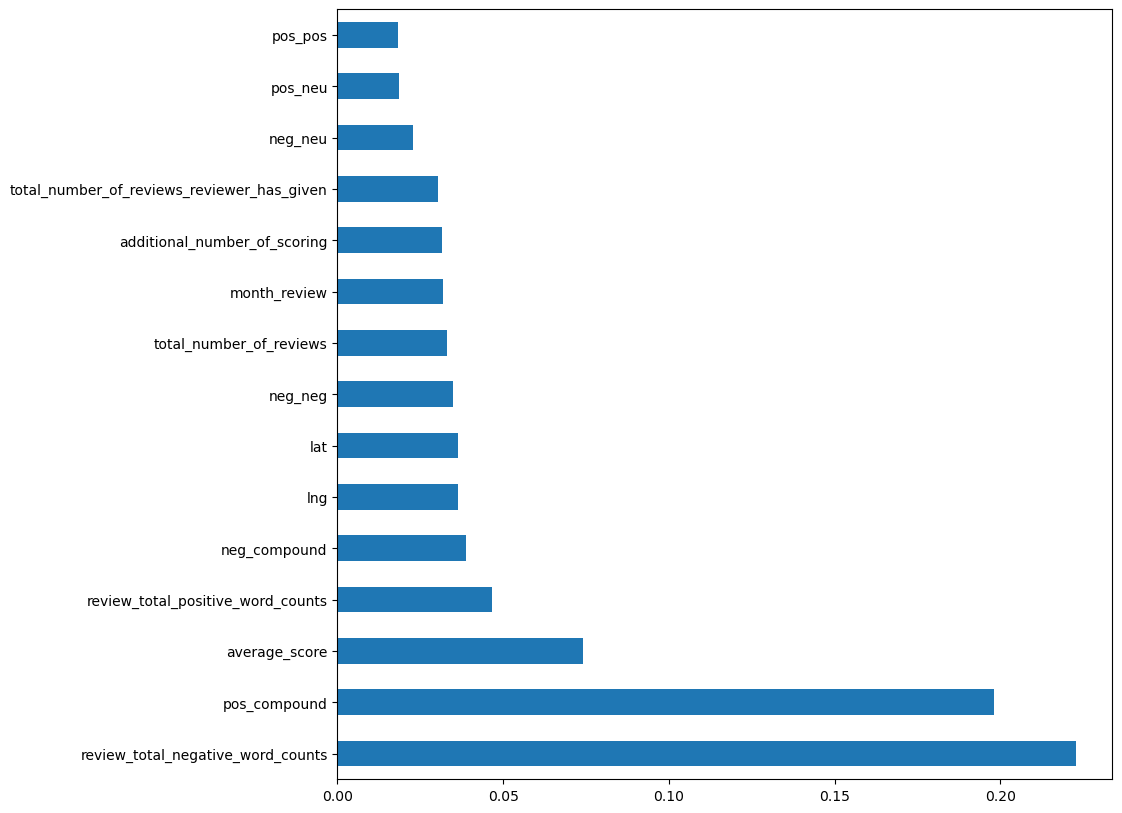

In [51]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [52]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,city_Amsterdam,...,Stayed 4 nights,Family with older children,Stayed 5 nights,Double Room,Standard Double Room,Superior Double Room,Deluxe Double Room,Double or Twin Room,Standard Double or Twin Room,Classic Double Room
97914,540,8.9,6,2274,14,7,51.555368,-0.286494,0.0,0,...,0,0,0,0,0,0,0,1,0,0
33208,465,8.9,10,2543,8,3,51.512246,-0.075733,0.0,0,...,0,0,0,1,0,0,0,0,0,0
99017,1005,8.3,16,3469,16,9,51.559095,-0.284704,0.0,0,...,0,0,0,0,0,0,0,1,1,0
37617,803,8.4,33,3911,5,1,52.376752,4.904618,0.0,1,...,0,0,0,0,0,0,0,0,0,0
7605,926,8.2,0,5770,41,1,52.368130,4.844085,0.0,1,...,0,1,0,1,1,0,0,0,0,0
127458,171,8.4,32,2189,0,5,45.488147,9.201661,0.0,0,...,0,0,0,0,0,0,0,0,0,0
16851,301,8.3,11,1939,19,13,52.359147,4.926360,0.0,1,...,0,0,0,1,0,1,0,0,0,0
66208,710,7.9,31,6511,8,5,48.875898,2.359050,0.0,0,...,0,0,0,0,0,0,0,1,1,0
104118,67,9.4,8,200,4,8,51.497562,-0.145551,0.0,0,...,0,0,0,0,0,0,0,0,0,0
48931,788,8.5,0,2635,8,10,51.512763,-0.099716,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [54]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [55]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


In [56]:
predict_submission

array([8.994, 7.089, 8.887, ..., 8.204, 9.647, 7.244])

In [57]:
list(sample_submission)

['reviewer_score', 'id']

In [58]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.994,488440
1,7.089,274649
2,8.887,374688
3,9.769,404352
4,9.721,451596
5,9.068,302161
6,8.055,317079
7,7.683,13963
8,8.373,159785
9,7.794,195089
